In [89]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Loading CSV files
patients_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/patients.csv')
admissions_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/admissions.csv')
chartevents_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/chartevents.csv')
labevents_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/labevents.csv')
diagnoses_icd_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/diagnoses_icd.csv.gz', compression='gzip', encoding='utf-8')
d_items_df = pd.read_csv('/Users/shankaranand/Downloads/Capstone/Database/d_items.csv.gz', compression='gzip', encoding='utf-8')
#path = '/Users/shankaranand/Downloads/Capstone/'

# we need to merge patients and admissions on the subject id
patient_adm_df = pd.merge(patients_df, admissions_df, on='subject_id')

# Preparing all features for this project

# Function to extract average measurements for a given itemid
def extract_measurement(df, itemid, label):
    filtered_df = df[df['itemid'] == itemid]
    avg_measurements = filtered_df.groupby('subject_id')['valuenum'].mean().reset_index(name=label)
    return avg_measurements

# we need to merge patients and admissions on the subject id
patient_adm_df = pd.merge(patients_df, admissions_df, on='subject_id')

# Convert 'admittime' and 'dischargetime' to datetime format
patient_adm_df['admittime'] = pd.to_datetime(patient_adm_df['admittime'])
patient_adm_df['dischtime'] = pd.to_datetime(patient_adm_df['dischtime'])

# Extract year from 'admittime' and 'dischargetime'
patient_adm_df['admission_year'] = patient_adm_df['admittime'].dt.year
patient_adm_df['discharge_year'] = patient_adm_df['dischtime'].dt.year

mimic_df = patient_adm_df[['subject_id', 'hospital_expire_flag', 'gender', 'anchor_age', 'admittime', 'dischtime', 'admission_year', 'discharge_year']]

# Created a dictionary to Map some itemids from d_items_df
lab_results_itemids = {
    'heart_rate': ('chartevents_df', 220045),
    'systolic_bp': ('chartevents_df', 220179),
    'diastolic_bp': ('chartevents_df', 220180),
    'respiratory_rate': ('chartevents_df', 220210),
    'temperature': ('chartevents_df', 223761),  
    'SpO2': ('chartevents_df', 220277),
    'Urine Output': ('chartevents_df', 227519),
    'Admission_Weight': ('chartevents_df', 226512), #in kg
    'Height': ('chartevents_df', 226730), #in cm
    'Hematocrit': ('labevents_df', 50810),
    'RBC': ('labevents_df', 51493),
    'MCH': ('labevents_df', 51248),
    'MCHC': ('labevents_df', 51249),
    'MCV': ('labevents_df', 51250),
    'RDW': ('labevents_df', 51277),
    'Leucocyte': ('labevents_df', 51241),
    'Platelets': ('labevents_df', 51265),
    'Neutrophils': ('labevents_df', 51256),
    'Basophils': ('labevents_df', 51146),
    'Lymphocyte': ('labevents_df', 51244),
    'PT': ('labevents_df', 51274),
    'INR': ('labevents_df', 51237),
    'NT-proBNP': ('labevents_df', 50963),
    'Creatine kinase': ('labevents_df', 50911),
    'Creatinine': ('labevents_df', 229761),
    'Urea nitrogen': ('labevents_df', 51006),
    'Glucose': ('labevents_df', 50931),
    'Blood potassium': ('labevents_df', 50822),
    'Blood sodium': ('labevents_df', 52455),
    'Blood calcium': ('labevents_df', 50893),
    'Chloride': ('labevents_df', 50902),
    'Anion gap': ('labevents_df', 50868),
    'Magnesium ion': ('labevents_df', 50960),
    'PH': ('labevents_df', 50820),
    'Bicarbonate': ('labevents_df', 50882),
    'Lactic acid': ('labevents_df', 225668),
    'PCO2': ('labevents_df', 50818),
    'Ejection Fraction': ('labevents_df', 227008),
    'Hypertension': ('diagnoses_icd_df', ['I10']),
    'Atrial Fibrillation': ('diagnoses_icd_df', ['I48']),
    'CHD no MI': ('diagnoses_icd_df', ['I25']),  # Exclude I21 in queries/analysis
    'Diabetes': ('diagnoses_icd_df', ['E10', 'E11']),
    'Deficiency Anemias': ('diagnoses_icd_df', ['D50', 'D51', 'D52']),
    'Depression': ('diagnoses_icd_df', ['F32', 'F33']),
    'Hyperlipidemia': ('diagnoses_icd_df', ['E78']),
    'Renal Failure': ('diagnoses_icd_df', ['N17', 'N18', 'N19']),
    'COPD': ('diagnoses_icd_df', ['J44'])
}

# Loop through measurement_itemids to extract each measurement and merge it into the mimic_df
for label, (df_name, itemid) in lab_results_itemids.items():
    if label not in mimic_df.columns:  # Check if the column already exists
        if df_name in ['chartevents_df', 'labevents_df']:  # Ensure it's a numerical measurement
            # Use eval to get the dataframe variable by name. Be cautious with eval and ensure df_name is controlled.
            temp_df = extract_measurement(eval(df_name), itemid, label)
            mimic_df = pd.merge(mimic_df, temp_df, on='subject_id', how='left', sort=False)

mimic_df['BMI'] = mimic_df['Admission_Weight'] / (mimic_df['Height'] ** 2)            
mimic_df = mimic_df.rename(columns={'subject_id': 'id', 'anchor_age': 'age', 'hospital_expire_flag': 'target_hosp_expire_flag'})            
            
print(mimic_df.dtypes)
#print(mimic_df.head())
#print(mimic_df.columns)


#mimic_df.to_excel(path + 'mimic_data.xlsx', index=False, engine='openpyxl')

print("Done")

id                                  int64
target_hosp_expire_flag             int64
gender                             object
age                                 int64
admittime                  datetime64[ns]
dischtime                  datetime64[ns]
admission_year                      int64
discharge_year                      int64
heart_rate                        float64
systolic_bp                       float64
diastolic_bp                      float64
respiratory_rate                  float64
temperature                       float64
SpO2                              float64
Urine Output                      float64
Admission_Weight                  float64
Height                            float64
Hematocrit                        float64
RBC                               float64
MCH                               float64
MCHC                              float64
MCV                               float64
RDW                               float64
Leucocyte                         

In [75]:
# 1. Creating the continuous features 
continuous_features = mimic_df.select_dtypes(include=[np.number]).columns.tolist()

# 'id' is not a feature to analyze and 'target_hosp_expire_flag' is the target
continuous_features.remove('id')
continuous_features.remove('target_hosp_expire_flag')

print('continuous_features: ')
print(len(continuous_features))

continuous_features: 
42


In [65]:
# 1. Creating the categorical features
categorical_features = mimic_df.select_dtypes(include=['object', 'category']).columns.tolist()

categorical_features.append('target_hosp_expire_flag')

print(categorical_features)

['gender', 'target_hosp_expire_flag']


In [68]:
# 2. Create continuous data quality report
Contin_dqrep = mimic_df[continuous_features].describe()

Contin_dqrep

,age,admission_year,discharge_year,heart_rate,systolic_bp,diastolic_bp,respiratory_rate,temperature,SpO2,Urine Output,...,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,Ejection Fraction,BMI
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,274.000000,275.000000,0.0,...,274.000000,275.000000,275.000000,275.000000,239.000000,275.000000,0.0,238.000000,0.0,182.000000
mean,61.043636,2152.920000,2152.938182,91.012900,116.652390,64.028515,19.300910,98.475856,96.700932,NaN,...,8.572013,101.191719,14.624363,2.015600,7.361708,25.130685,NaN,41.592229,NaN,0.003099
std,14.440600,24.973726,24.961426,11.726598,14.256450,8.269040,3.107222,0.574763,1.373421,NaN,...,0.486057,4.040638,2.531116,0.196370,0.055175,2.664575,NaN,8.655053,NaN,0.001439
min,21.000000,2110.000000,2110.000000,63.665635,88.900000,35.405660,10.452830,96.500000,91.405405,NaN,...,7.350000,89.086957,10.000000,1.500000,7.170000,16.333333,NaN,25.500000,NaN,0.001705
25%,52.500000,2136.000000,2136.000000,84.222236,107.836735,59.336170,16.942890,98.135294,95.766614,NaN,...,8.297959,97.638889,13.176692,1.862264,7.329000,24.269231,NaN,36.000000,NaN,0.002575
50%,60.000000,2148.000000,2148.000000,88.473684,117.857143,64.310897,19.388889,98.490909,96.966667,NaN,...,8.589051,101.863636,14.000000,2.000552,7.362500,25.123153,NaN,41.777778,NaN,0.002828
75%,70.000000,2176.000000,2176.000000,99.997664,124.834430,68.909091,20.957187,98.750000,97.478947,NaN,...,8.806818,103.909091,16.216024,2.114545,7.402727,26.750000,NaN,44.304348,NaN,0.003667
max,91.000000,2201.000000,2201.000000,114.066667,158.000000,88.691450,27.705882,100.311765,99.766667,NaN,...,10.256250,119.352941,26.833333,3.000000,7.465000,31.423077,NaN,69.700000,NaN,0.019796


In [70]:
# 2. Create categorical data quality report
Categ_dqrep = mimic_df[categorical_features].describe()
Categ_dqrep

,target_hosp_expire_flag
count,275.000000
mean,0.054545
std,0.227505
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


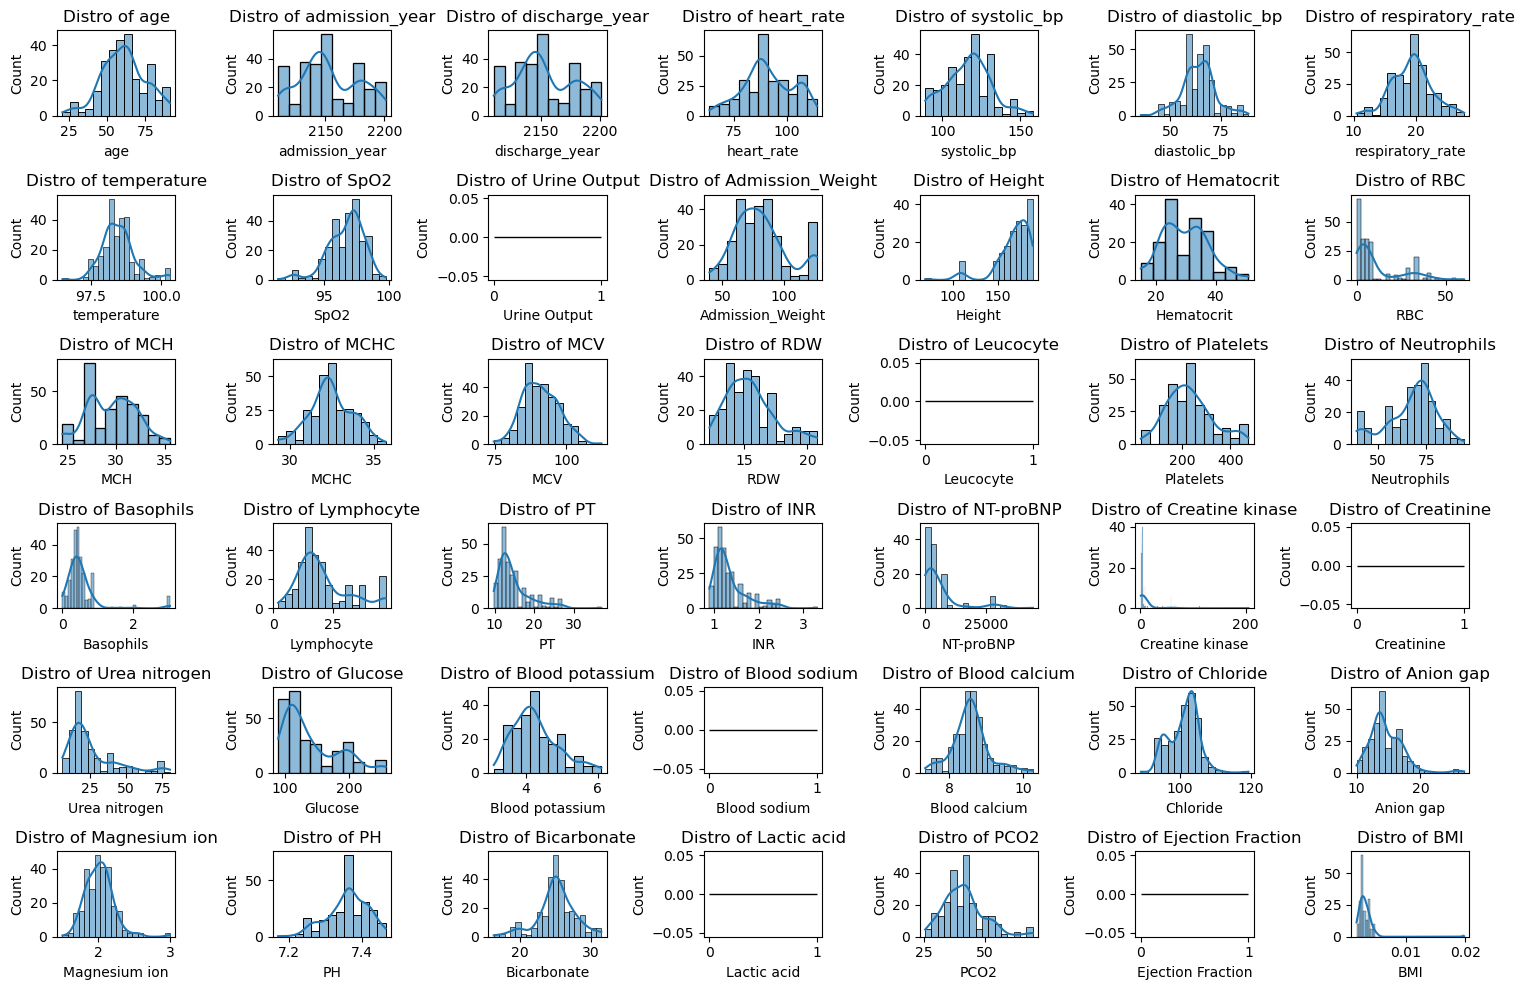

In [80]:
# 3. Visualization of Continuous features
plt.figure(figsize=(15,10))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(6, 7, i)
    sns.histplot(mimic_df[feature], kde=True)
    plt.title(f'Distro of {feature}')
plt.tight_layout()

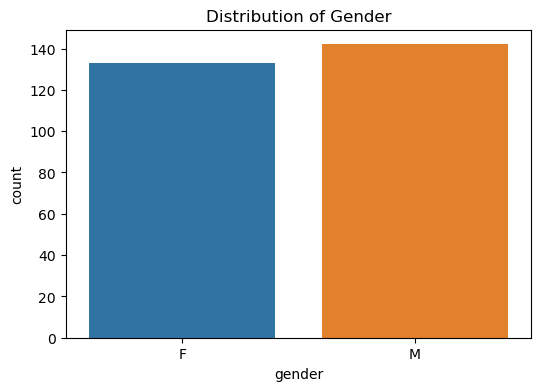

In [81]:
# 3. Visualization of Categorical features
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=mimic_df)
plt.title('Distribution of Gender')
plt.show()

In [85]:
# 4. Identifying the Outliers for continuous variable
outliers_summary = {}
for feature in continuous_features:
    Q1 = mimic_df[feature].quantile(0.25)
    Q3 = mimic_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_b = Q1 - 1.5 * IQR
    upper_b = Q3 + 1.5 * IQR
    
    outliers = mimic_df[(mimic_df[feature] < lower_b) | (mimic_df[feature] > upper_b)][feature]
    outliers_summary[feature] = {'IQR': IQR, 'Lower Bound': lower_b, 'Upper Bound': upper_b, 'Outliers': outliers.tolist()} 

outliers_df = pd.DataFrame.from_dict(outliers_summary, orient='index')
outliers_df['Outliers'] = outliers_df['Outliers'].apply(lambda x: ', '.join(map(str, x)))
outliers_df.to_excel(path + 'outliers_summary.xlsx', index=False, engine='openpyxl')  
outliers_summary

{'age': {'IQR': 17.5,
  'Lower Bound': 26.25,
  'Upper Bound': 96.25,
  'Outliers': [21, 21, 26]},
 'admission_year': {'IQR': 40.0,
  'Lower Bound': 2076.0,
  'Upper Bound': 2236.0,
  'Outliers': []},
 'discharge_year': {'IQR': 40.0,
  'Lower Bound': 2076.0,
  'Upper Bound': 2236.0,
  'Outliers': []},
 'heart_rate': {'IQR': 15.77542814662398,
  'Lower Bound': 60.55909402438508,
  'Upper Bound': 123.660806610881,
  'Outliers': []},
 'systolic_bp': {'IQR': 16.99769513068385,
  'Lower Bound': 82.34019199785178,
  'Upper Bound': 150.33097252058718,
  'Outliers': [150.7910447761194,
   150.7910447761194,
   158.0,
   156.00743494423793,
   153.75925925925927]},
 'diastolic_bp': {'IQR': 9.57292069632495,
  'Lower Bound': 44.97678916827853,
  'Upper Bound': 83.26847195357833,
  'Outliers': [85.0,
   85.0,
   85.0,
   85.34375,
   85.34375,
   35.405660377358494,
   83.49253731343283,
   83.49253731343283,
   85.56521739130434,
   88.6914498141264]},
 'respiratory_rate': {'IQR': 4.014296101452

In [87]:
# Transformation

# Binning 'age' into categories
age_bins = [0, 18, 30, 45, 60, 75, 90, 120]
age_labels = ['<18', '18-29', '30-44', '45-59', '60-74', '75-89', '90+']
mimic_df['Age_Group'] = pd.cut(mimic_df['age'], bins=age_bins, labels=age_labels, right=False)

# Categorizing 'BMI' based on WHO standards
bmi_bins = [0, 18.5, 25, 30, 40, np.inf]
bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese', 'Severely obese']
mimic_df['BMI_Category'] = pd.cut(mimic_df['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

# transforming 'heart_rate' into categories (the bins and labels are illustrative)
heart_rate_bins = [0, 60, 100, 120, np.inf]
heart_rate_labels = ['Low', 'Normal', 'Elevated', 'High']
mimic_df['Heart_Rate_Category'] = pd.cut(mimic_df['heart_rate'], bins=heart_rate_bins, labels=heart_rate_labels, right=False)

# Display the transformed features
print(mimic_df[['age', 'Age_Group', 'BMI', 'BMI_Category', 'heart_rate', 'Heart_Rate_Category']].head())

# Extracting month from 'admittime'
mimic_df['Admit_Month'] = mimic_df['admittime'].dt.month

# Extracting day of the week from 'dischtime' (0=Monday, 6=Sunday)
mimic_df['Discharge_DayOfWeek'] = mimic_df['dischtime'].dt.dayofweek

# Display the datetime transformations
print(mimic_df[['admittime', 'Admit_Month', 'dischtime', 'Discharge_DayOfWeek']].head())

   age Age_Group       BMI BMI_Category  heart_rate Heart_Rate_Category
0   21     18-29  0.002569  Underweight   91.453125              Normal
1   21     18-29  0.002569  Underweight   91.453125              Normal
2   72     60-74  0.003474  Underweight  107.669441            Elevated
3   72     60-74  0.003474  Underweight  107.669441            Elevated
4   72     60-74  0.003474  Underweight  107.669441            Elevated
            admittime  Admit_Month           dischtime  Discharge_DayOfWeek
0 2125-03-19 16:58:00            3 2125-03-28 13:37:00                    2
1 2125-02-27 07:15:00            2 2125-03-06 14:25:00                    1
2 2137-08-04 00:07:00            8 2137-09-02 17:05:00                    0
3 2137-02-24 10:00:00            2 2137-03-19 15:45:00                    1
4 2136-12-31 21:40:00           12 2137-01-03 17:05:00                    3


In [88]:
# Normalizing Data - Using MinMaxScaler
scaler = MinMaxScaler()
mimic_df_scaled = mimic_df.copy()
mimic_df_scaled[continuous_features] = scaler.fit_transform(mimic_df_scaled[continuous_features])

# Display part of the scaled DataFrame for verification
print(mimic_df_scaled[continuous_features].head())

        age  admission_year  discharge_year  heart_rate  systolic_bp  \
0  0.000000        0.164835        0.164835    0.551328     0.160637   
1  0.000000        0.164835        0.164835    0.551328     0.160637   
2  0.728571        0.296703        0.296703    0.873074     0.133545   
3  0.728571        0.296703        0.296703    0.873074     0.133545   
4  0.728571        0.285714        0.296703    0.873074     0.133545   

   diastolic_bp  respiratory_rate  temperature      SpO2  Urine Output  ...  \
0      0.189438          0.349564     0.568416  0.722469           NaN  ...   
1      0.189438          0.349564     0.568416  0.722469           NaN  ...   
2      0.455217          0.532956     0.323722  0.778261           NaN  ...   
3      0.455217          0.532956     0.323722  0.778261           NaN  ...   
4      0.455217          0.532956     0.323722  0.778261           NaN  ...   

   Blood calcium  Chloride  Anion gap  Magnesium ion        PH  Bicarbonate  \
0       0.344

/Users/shankaranand/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/shankaranand/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [66]:
5. Transform data.
6. Normalize data.

SyntaxError: invalid syntax (1038901733.py, line 1)